- 경사하강법(Gradient Descent): 손실을 줄이기 위해 𝑊,𝑏를 “기울기 방향 반대로” 조금씩 이동
- 역전파(Backprop): 손실의 기울기를 층별로 빠르게 계산하는 방법(연쇄법칙)
- Epoch: 데이터 전체를 1회 학습
- Batch: 한 번 업데이트에 사용하는 데이터 묶음
- Batch 크기가 작을수록 업데이트가 자주 일어나고, 학습은 빨라질 수 있지만 출렁임(노이즈)가 커질 수 있음

### 1. 데이터(이진분류) 만들기

In [2]:
# 준비: 데이터(이진분류) 만들기
# 간단한 2D 데이터로 분류를 학습한다(로지스틱 회귀 형태)
# (-2, -2)와 (2, 2)를 중심으로 하는 두 개의 2차원 이진 분류 데이터를 생성하고, 학습을 위해 무작위로 섞는 코드
# 손실은 Binary Cross Entropy(BCE) 사용.

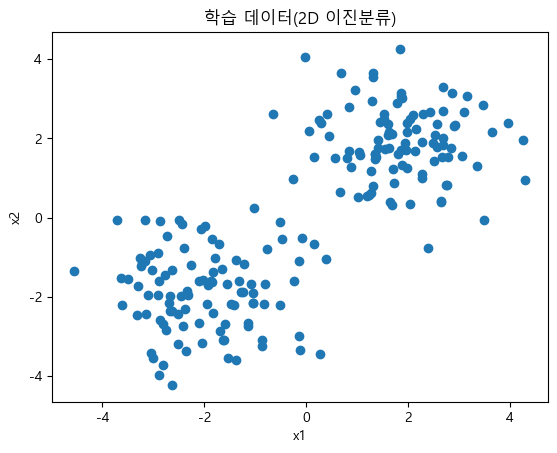

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rc

rc('font', family='Malgun Gothic')   # 맑은 고딕
plt.rcParams['axes.unicode_minus'] = False

np.random.seed(0) # 난수 고정:난수를 항상 동일하게 생성하도록 고정

# 간단한 2D 이진 분류 데이터 생성
# np.random.randn(n//2, 2) : 평균 0, 분산 1인 정규분포, 100개 × 2차원 데이터
# + np.array([-2, -2]) :모든 점을 (-2, -2) 방향으로 이동


n = 200  # 전체 데이터 개수: 200개
X0 = np.random.randn(n//2, 2) + np.array([-2, -2])  #클래스 0 데이터 생성,  클래스 0 데이터가 (-2, -2) 근처에 모여 있음
X1 = np.random.randn(n//2, 2) + np.array([ 2,  2])  # 클래스 1 데이터 생성, 클래스 1 데이터가 (2, 2) 근처에 모여 있음
X = np.vstack([X0, X1])  # 전체 입력 데이터 합치기: 세로로 이어 붙이기, 2차원 입력 특성
y = np.vstack([np.zeros((n//2, 1)), np.ones((n//2, 1))])  #정답 레이블 생성, 클래스 0 → 레이블 0,  클래스 1 → 레이블 1

# 데이터 섞기
# 처음엔 클래스 0 → 클래스 1 순서로 정렬됨,  그대로 학습하면 편향된 학습 발생 가능
idx = np.random.permutation(n)  # 0~199를 무작위로 섞은 인덱스 생성
X, y = X[idx], y[idx]

# 시각화
plt.figure()
plt.scatter(X[:,0], X[:,1])
plt.title("학습 데이터(2D 이진분류)")
plt.xlabel("x1"); plt.ylabel("x2")
plt.show()


### 2. 경사하강법 (기울기로 W,b 업데이트)

#### 핵심 함수들

- 로지스틱 회귀 / 이진 분류에서 가장 기본이 되는 시그모이드 함수와 이진 교차 엔트로피 손실(Binary Cross Entropy, BCE)를 정의
- 로지스틱 회귀에서 확률 예측과 그에 대한 이진 분류 손실을 계산하기 위한 핵심 함수들이다.

In [4]:
#시그모이드 함수 : 입력값 𝑧를 확률(0~1) 로 변환
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Binary Cross Entropy 손실 함수 : y_true: 실제 정답 (0 또는 1) , y_prob: 모델이 예측한 확률값 (0~1)
def bce_loss(y_true, y_prob):
    eps = 1e-12  # 수치 안정성(numerical stability) 을 위한 값, log(0) → 무한대(-∞) 발생,  학습 중 NaN 오류 방지, 확률을 [1e-12, 1-1e-12] 범위로 제한
    y_prob = np.clip(y_prob, eps, 1-eps)
    return -np.mean(y_true*np.log(y_prob) + (1-y_true)*np.log(1-y_prob))  # BCE 손실 계산


In [5]:
# epsilon(ε):수학·수치해석에서 “0은 아니지만, 0에 매우 가까운 값”

### 3. “기울기(gradient)”를 이용한 업데이트

- 로지스틱 회귀(Logistic Regression) 를 경사하강법(BGD / SGD / 미니배치 GD) 으로 학습하기 위한 훈련 함수

In [12]:
# batch_size 설정에 따라
# None → Batch GD : 한 번에 모든 데이터
# 1 → SGD
# >1 → Mini-batch GD


def train_logistic_gd(X, y, lr=0.1, epochs=50, batch_size=None):
    n, d = X.shape  # 데이터 차원 추출 : n: 샘플 개수, d: 특성(feature) 개수
    W = np.zeros((d, 1))  # 가중치 초기화, 가중치 벡터 𝑊=차원: (d, 1)0으로 초기화
    b = 0.0  # 편향(bias) 초기화

    loss_hist = []  #손실 기록용 리스트 : 각 epoch마다 계산한 손실값 저장

    for epoch in range(epochs):  # 에폭(epoch)마다 데이터를 섞고,그 다음 Batch / Mini-batch / SGD 방식에 맞게 배치를 만드는 부분
        # 배치 학습을 위해 매 epoch마다 섞기
        perm = np.random.permutation(n)
        Xs, ys = X[perm], y[perm]  # perm: 0~n-1 인덱스를 무작위로 섞음

        if batch_size is None:  # full batch : 데이터를 나누지 않음,전체 데이터를 하나의 배치로 취급
            batches = [(Xs, ys)]
        else:          # Mini-batch / SGD 인 경우 
            batches = []  # batches 리스트 생성
            for i in range(0, n, batch_size):  # batch_size 간격으로 데이터 자르기
                batches.append((Xs[i:i+batch_size], ys[i:i+batch_size]))

        # 미니배치 반복(=한 epoch 안에서 여러 번 업데이트)
        for Xb, yb in batches:
            z = Xb @ W + b
            y_prob = sigmoid(z)

            # ---- Backprop의 핵심 결과(출력층에서 시작): dz = y_hat - y ----
            dz = (y_prob - yb)  # (m,1)

            dW = (Xb.T @ dz) / len(Xb)
            db = np.mean(dz)

            # 경사하강법 업데이트
            W -= lr * dW
            b -= lr * db

        # epoch 끝에서 전체 손실 기록(평가)
        y_prob_all = sigmoid(X @ W + b)
        loss_hist.append(bce_loss(y, y_prob_all))

    return W, b, loss_hist


### 4. Batch vs Epoch 차이를 실험으로 확인

- 실험: batch_size를 바꿔서 Loss 곡선을 비교
- Full Batch (한 epoch당 1번 업데이트)
- Mini Batch (한 epoch당 여러 번 업데이트)
- SGD (batch_size=1, 업데이트 매우 잦음) Stochastic Gradient Descent

- 같은 로지스틱 회귀 모델을 세 가지 서로 다른 경사하강법 방식으로 학습시켜서 학습 특성(손실 곡선, 수렴 안정성)을 비교하기 위한 부분

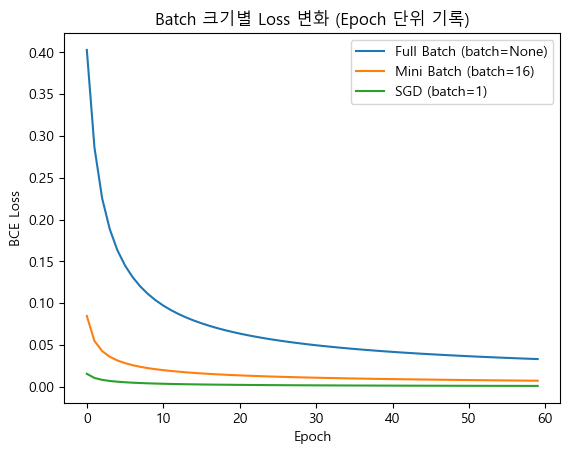

In [10]:
# 하이퍼파라미터
epochs = 60
lr = 0.2

# 1) (Full) Batch GD
W1, b1, loss_full = train_logistic_gd(X, y, lr=lr, epochs=epochs, batch_size=None) #Full Batch GD

# 2) Mini-batch (예: 한 번에 16개 데이터씩 사용)
W2, b2, loss_mini = train_logistic_gd(X, y, lr=lr, epochs=epochs, batch_size=16)

# 3) SGD (batch_size=1)
W3, b3, loss_sgd = train_logistic_gd(X, y, lr=lr, epochs=epochs, batch_size=1) # 데이터 1개당 1번 업데이트

plt.figure()
plt.plot(loss_full, label="Full Batch (batch=None)")
plt.plot(loss_mini, label="Mini Batch (batch=16)")
plt.plot(loss_sgd, label="SGD (batch=1)")
plt.title("Batch 크기별 Loss 변화 (Epoch 단위 기록)")
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.legend()
plt.show()


#### “Epoch vs Batch”를 숫자로 체감하기

- Epoch = 데이터 전체를 한 바퀴 도는 것
- Batch = 한 번에 학습하는 데이터 묶음
- 업데이트 횟수 = epoch 당 (데이터 수 / batch_size)

In [17]:
n = len(X)
for bs in [None, 16, 1, 32]:
    if bs is None:
        updates_per_epoch = 1
        name = "Full Batch"
    else:
        updates_per_epoch = int(np.ceil(n/bs))
        name = f"batch={bs}"
    print(f"{name:>10} | epoch당 업데이트 횟수 ≈ {updates_per_epoch}")


Full Batch | epoch당 업데이트 횟수 ≈ 1
  batch=16 | epoch당 업데이트 횟수 ≈ 13
   batch=1 | epoch당 업데이트 횟수 ≈ 200
  batch=32 | epoch당 업데이트 횟수 ≈ 7


### 5. 학습된 로지스틱 회귀 모델의 결정 경계(decision boundary) 를 2차원 데이터 위에 시각화 결정경계 시각화

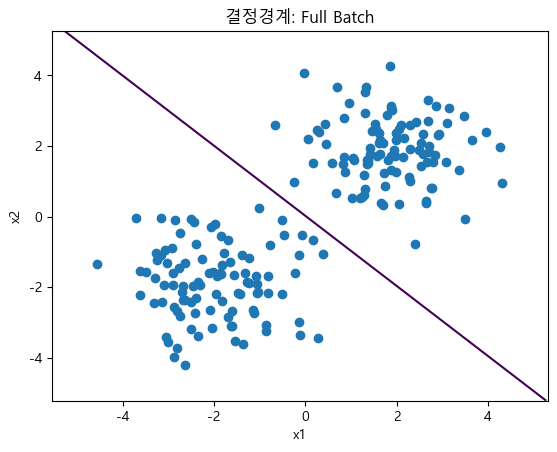

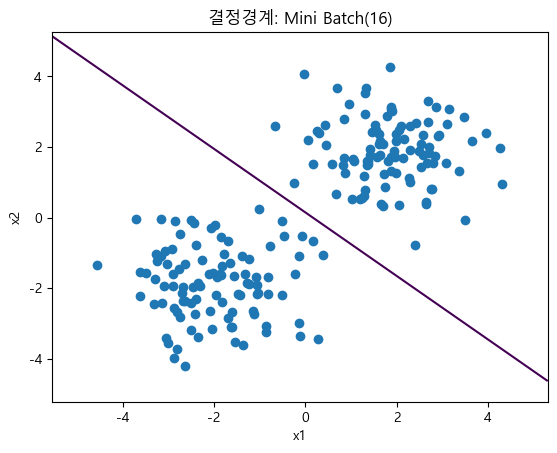

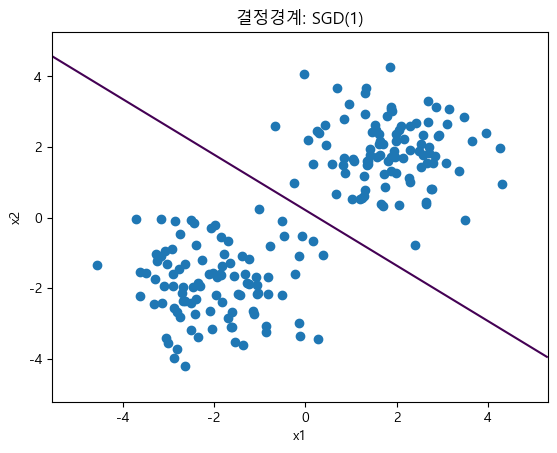

In [11]:
# 함수 정의
def plot_boundary(W, b, X, y, title):
    plt.figure() # 새 그림 생성
    plt.scatter(X[:,0], X[:,1])  # 데이터 산점도, 2차원 입력 데이터 시각화 (x1, x2) 좌표에 점 표시
    x1_min, x1_max = X[:,0].min()-1, X[:,0].max()+1  # 좌표 범위 설정
    x2_min, x2_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x1_min, x1_max, 200),  #격자(grid) 생성 : x1, x2 공간을 200×200 격자로 나눔
                         np.linspace(x2_min, x2_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]  # 격자 점 정리 ravel() → 1차원으로 펼침
    prob = sigmoid(grid @ W + b).reshape(xx.shape)  # 각 점에서의 예측 확률 계산, sigmoid(z) → 클래스 1 확률,reshape → 격자 형태로 복원

    plt.contour(xx, yy, prob, levels=[0.5])  # 결정 경계 그리기: threshold 0.5 경계
    plt.title(title)
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.show()

plot_boundary(W1, b1, X, y, "결정경계: Full Batch")
plot_boundary(W2, b2, X, y, "결정경계: Mini Batch(16)")
plot_boundary(W3, b3, X, y, "결정경계: SGD(1)")


- 이 함수가 보여주는 것
- 점: 실제 데이터
- 선: 모델이 학습한 분류 기준
- 서로 다른 학습 방식(GD / SGD / Mini-batch)의 → 결정 경계 차이 비교 가능